In [1]:
#load modules
import datacube
from datacube.storage import masking
from datacube import Datacube
from datetime import datetime
from skimage import exposure

import rasterio
from datacube_stats.statistics import GeoMedian
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import xarray as xr

import geopandas as gpd
from sklearn.ensemble import ExtraTreesClassifier
import datacube_stats
import os
# Replace '156' and 'ck9738' with the path to your own home directory on the VDI
s2aws = Datacube(config='/home/547/ck9738/datacube-s2.conf')

Failed to resolve driver datacube.plugins.index::s3aio_index


In [2]:
def array_topanda_s(array):
    a,b = array.shape
    length_be = int(a)+int(b)
    flat = array.stack(z=('dim_0','dim_1'))
    #ones_array = np.ones_like(flat)
    #ones_array = np.where(flat)
    panda_series = pd.Series(flat)
    return(panda_series)

In [3]:
"""canberra east 62_-159
        'lat': (-35.219946, -35.404461),
        'lon': (149.12468, 149.413767),"""

"canberra east 62_-159\n        'lat': (-35.219946, -35.404461),\n        'lon': (149.12468, 149.413767),"

In [4]:
def load_gfif_full(file_name, x):
    #file_string = 'old_DLCD/'+file_name+'.tif'

    dataset = rasterio.open(file_name) #open using Raterio
    {i: dtype for i, dtype in zip(dataset.indexes, dataset.dtypes)}
    data_array = dataset.read(x) #read selected band into np array
    data_xr = xr.DataArray(data_array) #turn into Xr array for fuctionality #Now don't need xr yet
    return(data_xr) #return np array into program 
    


smad_array = load_gfif_full('/g/data/u46/users/dxr251/woody-v6/woody_62_-159.tif',1)
gmax_array = load_gfif_full('/g/data/u46/users/dxr251/woody-v6/woody_62_-159.tif',2)
gmin_array = load_gfif_full('/g/data/u46/users/dxr251/woody-v6/woody_62_-159.tif',3)

In [5]:
#/g/data/u46/users/ck9738/Datasets/ML_for_smad_green/shapefiles_train_4class/classes.tiff
classification_key = load_gfif_full('/g/data/u46/users/ck9738/Datasets/ML_for_smad_green/shapefiles_train_4class/c3classez_two.tif',1)#for old dlcd files all only have ONE band (are single year)

In [6]:
classification_key 

<xarray.DataArray (dim_0: 1000, dim_1: 1000)>
array([[2, 2, 0, ..., 2, 2, 2],
       [2, 2, 2, ..., 2, 2, 2],
       [0, 2, 2, ..., 2, 2, 2],
       ...,
       [2, 2, 0, ..., 0, 0, 0],
       [2, 2, 0, ..., 0, 0, 0],
       [2, 2, 2, ..., 0, 0, 0]], dtype=uint8)
Dimensions without coordinates: dim_0, dim_1

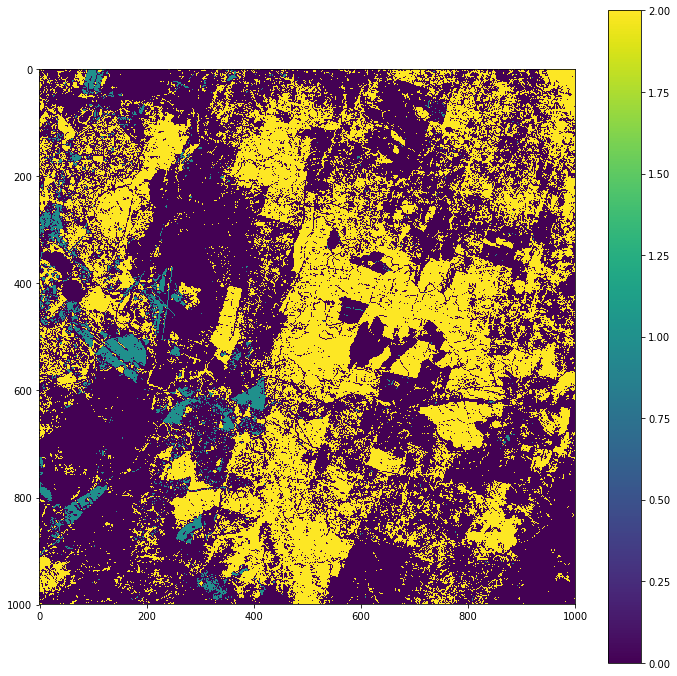

In [7]:
fig, ax = plt.subplots(figsize = (12,12))
cax = ax.imshow(classification_key)
plt.colorbar(cax)
plt.show()

In [8]:
np.asarray([np.nan, 7, 2.5, 'NaN'], dtype=np.float32)

array([nan, 7. , 2.5, nan], dtype=float32)

In [9]:
#turn classification data into a dataframe
class_series = array_topanda_s(classification_key)

output_panda = pd.DataFrame(class_series, columns=['class'])
#output_panda = output_panda.replace(to_replace=0, value=np.nan)
# output_panda = output_panda.replace(to_replace=2, value=0)
# output_panda = output_panda.replace(to_replace=1, value=0)
# output_panda = output_panda.replace(to_replace=3, value=0)
# output_panda = output_panda.replace(to_replace=5, value=0)
# output_panda = output_panda.replace(to_replace=4, value=1)

output_panda

,class
0,2
1,2
2,0
3,0
4,0
5,0
6,0
7,0
8,0
9,0


In [10]:
#add bands from the smad/green dataset one by one
output_panda['1'] = array_topanda_s(smad_array)
output_panda['2'] = array_topanda_s(gmax_array)
output_panda['3'] = array_topanda_s(gmin_array)

output_panda = output_panda.dropna(axis=0, how='any')
output_panda

,class,1,2,3
0,2,0.001997,0.538996,0.538187
1,2,0.004066,0.621558,0.604857
2,0,0.003615,0.528102,0.518854
3,0,0.001312,0.393211,0.392730
4,0,0.001213,0.410002,0.410583
5,0,0.003394,0.522391,0.515610
6,0,0.006515,0.578312,0.559627
7,0,0.005436,0.454934,0.446399
8,0,0.005700,0.475808,0.466188
9,0,0.012629,0.602720,0.577991


In [11]:
output_panda.to_csv('/g/data/u46/users/ck9738/Datasets/ML_for_smad_green/training_datasets/train_three_class_one.csv')